In [183]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, \
                            compute_log_likelihood_by_week, \
                            ACTUAL_TRAJ, UNCERTAINTY_PARAMS, \
                            get_positives_by_week, get_true_positives_by_week
import sklearn 
from sklearn.preprocessing import PolynomialFeatures

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]


from vax_sims_LHS_samples import *

import numpy as np

from scipy.stats import poisson, norm

from statsmodels.api import OLS

import matplotlib.pyplot as plt 
import pandas as pd


In [3]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
    
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points
Loaded 160 points
Loaded 170 points
Loaded 180 points
Loaded 190 points
Loaded 200 points
Loaded 210 points
Loaded 220 points
Loaded 230 points
Loaded 240 points
Loaded 250 points
Loaded 260 points
Loaded 270 points
Loaded 280 points
Loaded 290 points
Loaded 300 points
Loaded 310 points
Loaded 320 points
Loaded 330 points
Loaded 340 points
Loaded 350 points
Loaded 360 points
Loaded 370 points
Loaded 380 points
Loaded 390 points
Loaded 400 points
Loaded 410 points
Loaded 420 points
Loaded 430 points
Loaded 440 points
Loaded 450 points
Loaded 460 points
Loaded 470 points
Loaded 480 points
Loaded 490 points
Loaded 500 points
Loaded 510 points
Loaded 520 points
Loaded 530 points
Loaded 540 points
Loaded 550 points
Loaded 560 points
L

In [4]:
len(sampled_points)

1000

In [184]:
def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)



In [199]:
UNCERTAINTY_PARAMS = ['vax_susc_mult', 'vax_transmission_mult', 'contacts_per_day_mult', 'outside_infection_rate_mult',
                      'cases_isolated_per_contact_trace', 'initial_ID_prevalence']

UNCERTAINTY_PARAM_RANGES = {
    'vax_susc_mult': (0.097608, 0.941192), # 0.5194 +/- 1.96 * 0.2152
    'vax_transmission_mult': (0.25, 1),
    'contacts_per_day_mult': (0.9,2.7),
    'outside_infection_rate_mult': (1, 5),
    'cases_isolated_per_contact_trace': (0.5,1.5),
    'initial_ID_prevalence': (0.003, 0.0054)
}

means = []
sds = []

for param in UNCERTAINTY_PARAMS:
    means.append(np.mean(UNCERTAINTY_PARAM_RANGES[param]))
    sds.append((UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*1.96))
    
PARAM_MEANS = dict(zip(UNCERTAINTY_PARAMS, means))
PARAM_SDS = dict(zip(UNCERTAINTY_PARAMS, sds))


In [201]:

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        loglik += np.log(norm.pdf(scaled_log_positives))
    
    return loglik

#def compute_log_posterior()




In [202]:

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

logliks = {}
for f in sampled_points:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/yz685/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0, 0.5, 'number of cases')

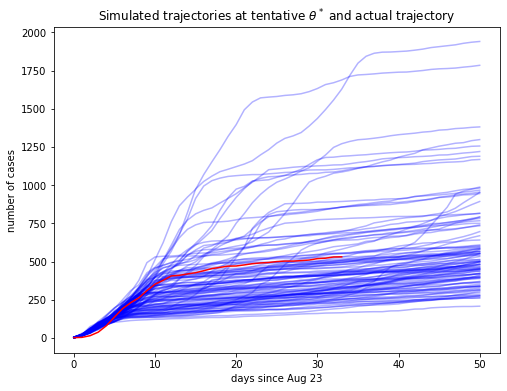

In [203]:

plt.figure(figsize=(8,6))
for i in range(len(aggregated_trajs['point_456_with_trajectories.dill'])):
    plt.plot(aggregated_trajs['point_456_with_trajectories.dill'][i], color='b', alpha=0.3)
plt.plot(np.cumsum(np.array(ACTUAL_TRAJ)), color='r')
plt.title(r'Simulated trajectories at tentative $\theta^*$ and actual trajectory')
plt.xlabel('days since Aug 23')
plt.ylabel('number of cases')

In [204]:

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks[f]) # log likelihood for corresponding param value
    

Text(0.5, 1.0, 'distribution of log likelihoods using weekly aggregation')

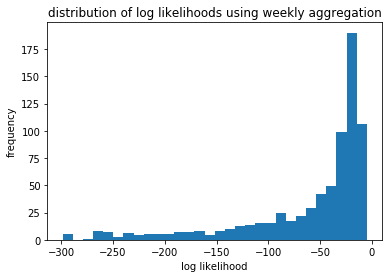

In [205]:
plt.hist([x for x in param_logliks[UNCERTAINTY_PARAMS[0]] 
          if x != float('-inf') and x >= -300], bins=30)
plt.xlabel("log likelihood")
plt.ylabel("frequency")
plt.title("distribution of log likelihoods using weekly aggregation")

In [206]:
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
#df['file_name'] = sampled_points
subdf = df
df.shape

(1000, 8)

In [207]:
df

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult
0,0.748766,0.833479,1.043564,2.515498,1.065157,0.006487,-102.746603,0.651268
1,0.707515,0.451851,1.708060,3.683021,0.532544,0.003432,-251.107682,0.546052
2,0.778271,0.498263,0.844716,2.662501,0.470991,0.003662,-25.880658,0.327567
3,0.722875,0.584793,2.346443,5.844724,0.795168,0.003987,-1437.944245,0.991918
4,0.682521,0.544387,1.234107,2.005781,1.229614,0.004297,-9.868776,0.458539
...,...,...,...,...,...,...,...,...
995,0.459572,0.701496,1.404153,2.090376,1.268446,0.003674,-12.160038,0.452682
996,0.522296,0.844224,1.894048,2.118457,1.098145,0.005324,-264.856083,0.835152
997,0.617936,0.485461,1.581759,2.538194,0.656435,0.004430,-56.027369,0.474502
998,0.844353,0.580883,1.862946,2.457950,0.454051,0.003804,-1437.944245,0.913720


In [214]:
log_priors = []

for row in range(df.shape[0]):
    log_prior = 0
    for param in UNCERTAINTY_PARAMS:
        log_prior -= 1/2 * (df.loc[row][param]-PARAM_MEANS[param])**2/PARAM_SDS[param]**2
    log_priors.append(log_prior)


In [217]:
df['log_prior'] = log_priors
df['log_posterior'] = df['log_likelihood'] + df['log_prior']

In [276]:
df

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,log_prior,log_posterior
0,0.748766,0.833479,1.043564,2.515498,1.065157,0.006487,-102.746603,0.651268,-9.639849,-112.386452
1,0.707515,0.451851,1.708060,3.683021,0.532544,0.003432,-251.107682,0.546052,-3.500583,-254.608265
2,0.778271,0.498263,0.844716,2.662501,0.470991,0.003662,-25.880658,0.327567,-5.698375,-31.579033
3,0.722875,0.584793,2.346443,5.844724,0.795168,0.003987,-1437.944245,0.991918,-5.446238,-1443.390483
4,0.682521,0.544387,1.234107,2.005781,1.229614,0.004297,-9.868776,0.458539,-2.027671,-11.896447
...,...,...,...,...,...,...,...,...,...,...
995,0.459572,0.701496,1.404153,2.090376,1.268446,0.003674,-12.160038,0.452682,-1.810126,-13.970165
996,0.522296,0.844224,1.894048,2.118457,1.098145,0.005324,-264.856083,0.835152,-2.810619,-267.666702
997,0.617936,0.485461,1.581759,2.538194,0.656435,0.004430,-56.027369,0.474502,-1.563434,-57.590803
998,0.844353,0.580883,1.862946,2.457950,0.454051,0.003804,-1437.944245,0.913720,-3.815855,-1441.760099


In [277]:
subdf_diff = subdf[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult', \
               'log_posterior']]
#subtract from entry with largest log -- to change to posterior
subdf_diff = subdf_diff.sub(subdf_diff.iloc[subdf['log_posterior'].idxmax()])

subdf_diff = subdf_diff.dropna(subset=['log_posterior'])
subdf_diff

,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,combined_spread_mult,log_posterior
0,2.134854,0.068241,0.002163,0.296662,-103.255431
1,3.302377,-0.464372,-0.000892,0.191447,-245.477244
2,2.281858,-0.525926,-0.000663,-0.027039,-22.448011
3,5.464080,-0.201749,-0.000338,0.637312,-1434.259461
4,1.625137,0.232697,-0.000027,0.103934,-2.765426
...,...,...,...,...,...
995,1.709732,0.271529,-0.000650,0.098077,-4.839143
996,1.737813,0.101229,0.001000,0.480546,-258.535681
997,2.157550,-0.340482,0.000106,0.119897,-48.459782
998,2.077306,-0.542866,-0.000520,0.559115,-1432.629078


In [278]:
params_diff = subdf_diff[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']]
logposterior_diff = subdf_diff['log_posterior']
quadratic = PolynomialFeatures(degree = 2,interaction_only=False,include_bias = False)


1.4063251023296632


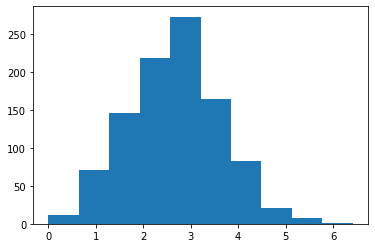

In [279]:
param_distances = np.sqrt(np.square(params_diff).sum(axis=1))

plt.hist(param_distances)
cutoff_radius = np.quantile(param_distances,0.1)
print(cutoff_radius)

In [280]:
reg_x = params_diff[param_distances < cutoff_radius]
reg_y = logposterior_diff[param_distances < cutoff_radius]
reg_x.reset_index(drop=True, inplace=True)
reg_y.reset_index(drop=True, inplace=True)

In [281]:
reg_input_quadratic = pd.DataFrame(quadratic.fit_transform(reg_x.to_numpy()),\
                                     columns = quadratic.get_feature_names(reg_x.columns))


In [292]:
norm_reg_input_quadratic = reg_input_quadratic / reg_input_quadratic.abs().max()


In [293]:
#norm_reg_input_quadratic.isnull().sum()
#np.isinf(norm_reg_input_quadratic).sum()
reg_y.isnull().sum()
#np.isinf(reg_y).sum()

0

In [294]:

model = OLS(reg_y, norm_reg_input_quadratic)
results = model.fit()

In [295]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          log_posterior   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              53.84
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                    2.06e-36
Time:                        11:21:54   Log-Likelihood:                         -656.59
No. Observations:                 100   AIC:                                      1341.
Df Residuals:                      86   BIC:                                      1378.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
outside_infection_rate_mult                                    226.5969    177.480      1.277      0.205    -126.221     579.415
cases_isolated_per_contact_trace                              -168.9588    139.760     -1.209      0.230    -446.793     108.875
initial_ID_prevalence                                         -246.8060    215.636     -1.145      0.256    -675.476     181.864
combined_spread_mult                                          -136.4471    210.746     -0.647      0.519    -555.397     282.502
outside_infection_rate_mult^2                                 -190.4266    209.345     -0.910      0.366    -606.590     225.737
outside_infection_rate_mult cases_isolated_per_contact_trace   237.0410    154.333      1.536      0.128     -69.762     543.844
outside_infection_rate_mult initial_ID_prevalence              264.6774    255.952      1.034      0.304    -244.138     773.492
outside_infection_rate_mult combined_spread_mult                93.3927    183.198      0.510      0.612    -270.792     457.577
cases_isolated_per_contact_trace^2                             -49.5986     98.052     -0.506      0.614    -244.520     145.323
cases_isolated_per_contact_trace initial_ID_prevalence         -46.1872     93.526     -0.494      0.623    -232.110     139.736
cases_isolated_per_contact_trace combined_spread_mult          436.6953     89.127      4.900      0.000     259.517     613.874
initial_ID_prevalence^2                                       -102.9363    120.570     -0.854      0.396    -342.622     136.749
initial_ID_prevalence combined_spread_mult                     316.5544    136.602      2.317      0.023      44.999     588.110
combined_spread_mult^2                                       -1560.5602    149.665    -10.427      0.000   -1858.084   -1263.036
==============================================================================
Omnibus:                       52.683   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.389
Skew:                          -1.527   Prob(JB):                     5.98e-71
Kurtosis:                      11.263   Cond. No.                         18.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [296]:
results.params

outside_infection_rate_mult                                      226.596861
cases_isolated_per_contact_trace                                -168.958833
initial_ID_prevalence                                           -246.806013
combined_spread_mult                                            -136.447139
outside_infection_rate_mult^2                                   -190.426573
outside_infection_rate_mult cases_isolated_per_contact_trace     237.041007
outside_infection_rate_mult initial_ID_prevalence                264.677425
outside_infection_rate_mult combined_spread_mult                  93.392735
cases_isolated_per_contact_trace^2                               -49.598626
cases_isolated_per_contact_trace initial_ID_prevalence           -46.187181
cases_isolated_per_contact_trace combined_spread_mult            436.695280
initial_ID_prevalence^2                                         -102.936323
initial_ID_prevalence combined_spread_mult                       316.554365
combined_spr

In [297]:
unnorm_coef = results.params / params_diff_quadratic.max()

In [298]:
unnorm_coef

outside_infection_rate_mult                                     1.152311e+02
cases_isolated_per_contact_trace                               -2.810531e+02
initial_ID_prevalence                                          -1.248344e+05
combined_spread_mult                                           -1.340070e+02
outside_infection_rate_mult^2                                  -4.924464e+01
outside_infection_rate_mult cases_isolated_per_contact_trace    2.695049e+02
outside_infection_rate_mult initial_ID_prevalence               6.807867e+04
outside_infection_rate_mult combined_spread_mult                6.387741e+01
cases_isolated_per_contact_trace^2                             -1.193020e+02
cases_isolated_per_contact_trace initial_ID_prevalence         -7.432269e+04
cases_isolated_per_contact_trace combined_spread_mult           1.596429e+03
initial_ID_prevalence^2                                        -2.633452e+07
initial_ID_prevalence combined_spread_mult                      4.382747e+05

In [299]:
# map regression results to hessian matrix

hessian = np.zeros((4,4))

counter = 0
for i in range(4):
    for j in range(i, 4):
        if i == j:
            hessian[i,j] = -2 * unnorm_coef[4+counter]
        else:
            hessian[i,j] = -unnorm_coef[4+counter]
        counter += 1

# fill in symmetric lower triangular part
for i in range(1,4):
    for j in range(i):
        hessian[i,j] = hessian[j,i]
    
print(hessian)

[[ 9.84892894e+01 -2.69504892e+02 -6.80786670e+04 -6.38774097e+01]
 [-2.69504892e+02  2.38604062e+02  7.43226929e+04 -1.59642854e+03]
 [-6.80786670e+04  7.43226929e+04  5.26690486e+07 -4.38274655e+05]
 [-6.38774097e+01 -1.59642854e+03 -4.38274655e+05  3.01048398e+03]]


In [300]:
# order of parameters in the matrix:
#   outside_infection_rate_mult                                     
#   cases_isolated_per_contact_trace                               
#   initial_ID_prevalence                                         
#   combined_spread_mult 

np.linalg.eig(hessian)


(array([ 5.26728885e+07, -1.55060185e+03,  8.65531499e+02,  1.92793551e+02]),
 array([[-1.29243266e-03,  3.72118737e-01, -2.96455789e-01,
          8.79568042e-01],
        [ 1.41123744e-03,  4.94419098e-01, -7.38683278e-01,
         -4.58142749e-01],
        [ 9.99963550e-01,  6.31963803e-03,  5.69643544e-03,
          7.15659350e-04],
        [-8.32090119e-03,  7.85517322e-01,  6.05333404e-01,
         -1.28315117e-01]]))

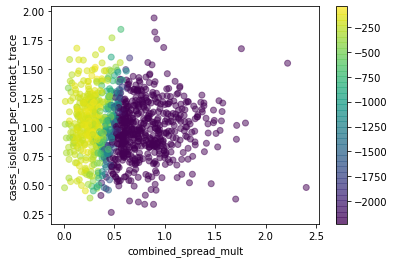

In [18]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

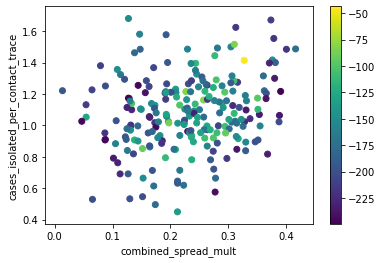

In [19]:
subdf = df[df['log_likelihood'] >= -250]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

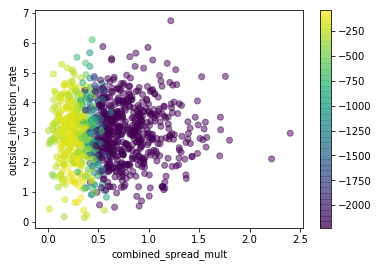

In [34]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



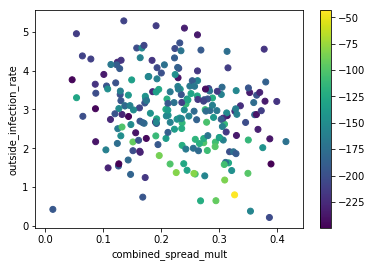

In [35]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()